# Microcanonical Molecular Dynamics Simulation
Velocity Verlet Algorithm; created 07/09/24

#### References
- D. Frenkel and B. Smit, *Understanding Molecular Simulation*, Academic Press, 2002.

## Libraries

In [1]:
import numpy as np
import sys
import os

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FormatStrFormatter
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["mathtext.fontset"] = "stix"

## Initial Parameters
All are in reduced units.

In [2]:
# Particle Parameters
m = 1 # Mass of particles
eps = 1 #epsilon
sig = 1 #sigma

# Initial Parameters
steps = 2500 # Number of time steps
N = 108 # Number of particles
L = 5.038789 # Side of box
rc = 2.5*sig #Cut off radius for interactions
dt = 0.01 # Time step
T = 0.728 # Initial Temperature

# Constants
kb = 1

# Useful Quantities
ecut = 4*eps*((sig/rc)**12 - (sig/rc)**6) # Potential at the cutoff; r = rc
r_range = np.linspace(0, L/2, num=100) # For radial distribution function - bins
density = m*N/L**3 # Density of particles

## Functions
The potential used is the truncated and shifted Lennard-Jones potential.
- gen_lattice: Generates values between 0 and L with a specified spacing whilst accounting for periodic boundary conditions.
- length: Difference in coordinates and distance between two particles taking into account the minimum image convention.
- energy: Returns the potential and kinetic energy of the system.
- force: Components of force due to Lennard-Jones interactions.
- update: Updates the position, velocity, and acceleration of each particle after a single time step.
- g: Number of particles within a range for the radial distribution function.

In [3]:
def gen_lattice(spacing):
    x = 0
    y = []
    while x < L-spacing: # To account for distance across periodic boundaries
        y = y + [x]
        x = x + spacing
    return y

In [4]:
def length(position):
    """
    Returns two arrays: the first containing the differences in coordinates and
    the second the distance between each pair of particles as an N X N matrix.

    Parameters
    ----------
    position: ndarray of floats, N x 3
        x, y, z coordinates of each particle.
    
    Returns
    -------
    diff: ndarray, N x N x 3
        Differences in coordinates between a particle and all other particles.
    
    Y: ndarray, N x N
        Distance squared between particles as a matrix Y, where Y[i,j] is the
        closest image distance squared between particle i and j.
    """
    
    Y = np.zeros((N, N))
    diff = np.zeros((N, N, 3))

    for i in range(N):
        diff[i] = position[i] - position #diff[i] is the difference in x/y/z coords of particle i to all other particles
        diff[i] = diff[i] - L*np.round(diff[i]/L, decimals=0) # difference between nearest image
        Y[i] = np.sum(diff[i]**2, axis=1) #Distance squared matrix

    return diff, Y


In [5]:
#Energy and force using Lennard-Jones

def energy(epsilon, sigma, position, velocity):
    """
    Returns the energy of the system (potential, kinetic).

    Parameters
    ----------
    epsilon: float
        Well depth.
    
    sigma: float
        Distance at which potential energy is zero.
    
    position: ndarray of floats, N x 3
        Position of each particle.

    velocity: ndarray of floats, N x 3
        x, y, z component of velocity of each particle.
    
    Returns
    -------
    pot: float
        Total potential energy of the system.

    kin: float
        Total kinetic energy of the system.
    """

    LJ_array = np.zeros((N,3))
    coord, dist = length(position)
    dist[dist>rc**2] = 0 # Sets potential to those with distances creater than rc to be 0 (truncate)

    sigma = sigma**2 # Working with dist^2 so easier to work with sig^2 too

    with np.errstate(divide='ignore', invalid='ignore'):
        r12 = (sigma/dist)**6
        r6 = (sigma/dist)**3
        LJ_array = 4*epsilon*(r12 - r6) - ecut # Shifts potential
        LJ_array[LJ_array == np.inf] = 0
        LJ_array = np.nan_to_num(LJ_array)

    pot = np.sum(LJ_array)
    kin = 0.5*m*np.sum(velocity**2)
    return pot, kin


def force(epsilon, sigma, position):
    """
    Returns the force due to the Lennard-Jones potential of each particle.
    
    Parameters
    ----------
    epsilon: float
        Well depth.
    
    sigma: float
        Distance at which potential energy is zero.
    
    position: ndarray of floats, N x 3
        Position of each particle.
    
    Returns
    -------
    force_tot: ndarray of floats, N x 3
        x, y, z component of force on each particle as a result of the total pair-wise interactions. [Used for updating acceleration]

    force_array: N x N x 3
        x, y, z component of force on particle i as a result of particle j. [Used for pressure calculation]
    """

    force_array = np.zeros((N,N,3))
    coord, dist = length(position)
    dist[dist>rc**2] = 0

    dist = np.repeat(dist[:, :, np.newaxis], 3, axis=2)
    # Repeats each column 3 times to allow for faster calculation (compared to for loop)
    # dist is now a N x N x 3 matrix, matching the shape of coord

    sigma = sigma**2

    with np.errstate(divide='ignore', invalid='ignore'):
        r12 = (sigma/dist)**6
        r6 = (sigma/dist)**3
        force_array = ((48*epsilon*coord)/dist)*(r12 - 0.5*r6)
        force_array[force_array == np.inf] = 0
        force_array = np.nan_to_num(force_array)
        force_tot = np.sum(force_array, axis=1)

    return force_tot, force_array


In [6]:
def update(position, velocity, acceleration, delta):
    """
    Returns the updated positions, velocities, and accelerations of the particles after one time step.
    
    Parameters
    ----------
    position: ndarray of floats, N x 3
        x, y, z coordinates of each particle.

    velocity: ndarray of floats, N x 3
        x, y, z component of velocity of each particle.

    acceleration: ndarray of floats, N x 3
        x, y, z coordinates of each particle.

    delta: float
        Time step.
    
    Returns
    -------
    ndarray of 3 ndarrys of floats
        Updated arrays of position, velocity, and acceleration of each particle.
    """
    
    new_r = (position + delta*velocity + 0.5*acceleration*delta**2) % L
    new_a = force(eps, sig, new_r)[0]/m
    new_v = velocity + 0.5*delta*(acceleration + new_a)
    return new_r, new_v, new_a

In [7]:
def g(position):
    """
    Returns the unnormalised radial distribution function (number of particles
    within a given range).

    Parameters
    ----------
    position: ndarray of floats, N x 3
        x, y, z coordinates of each particle.
    
    Returns
    -------
    ndarray
        The number of particles in each bin.
        
    """
    
    coord, dist = length(position)
    dist = np.sqrt(dist)

    counts, edges = np.histogram(dist[dist!=0], bins=r_range) # Histogram of all pairwise distances, excluding 0 (self)

    return counts/N # Average number density across all particles

#### Data Files
Code below creates a directory named "data" and contains function gen_file which generates .xyz data files, for use for visualisation. I used OVITO to visualise my simulation runs.

In [8]:
outdir="data"
try: #make directory if it does not exist
    os.mkdir(outdir)
except:
    pass

def gen_file(position,t):
    """
    Generates a .xyz file containing the coordinates of all particles.

    Parameters
    ----------
    position: ndarray of floats, N x 3
        x, y, z coordinates of each particle.

    t: float
        Time step.
    
    """
    
    fname=outdir+"/t"+str(t+1)+".xyz"
    f=open(fname,"w")
    f.write(str(N) + "\n") # number of atoms
    f.write('Lattice="'+ str(L) +" 0.0 0.0 0.0 " + str(L) +" 0.0 0.0 0.0 " + str(L) + '" '
            + "Properties="+"pos:R:3" + "\n") # Periodic bc not specified so are assumed
    for i in range(len(position)):
        f.write(str(position[i][0])+" "+str(position[i][1])+" "+str(position[i][2])+"\n")
    f.close

## Initialisation
- Randomise positions with coordinates according to gen_lattice with no duplicates.
- Randomise velocities such that they are within [-0.5, 0.5].
- Acceleration is given by the force due to the Lennard-Jones potential.
- Initial positions are saved as 'r0'.
- Velocities are then scaled to a set initial temperature.

In [9]:
#Initial conditions

values = gen_lattice(sig) # Array of values to choose from, separated by sig

r = set() # Prevents duplicates
while len(r) < N:
    initial = (np.random.choice(values), np.random.choice(values), np.random.choice(values))
    if initial not in r:
        r.add(initial)

r = np.array(list(r))
v = np.random.rand(N, 3) - 0.5 # Random velocities between -0.5 and 0.5

a = force(eps, sig, r)[0]/m # Initial acceleration

r0 = r

In [10]:
# Scaling velocities to initial temperature

v_com = np.sum(v,axis=0)/N # velocity centre of mass
v = v - v_com

U, KE = energy(eps, sig, r, v)

temp = 2*KE/(3*N*kb) # Instantaneous T of system; F&S Eq 4.2.2; Factor of 2 is due to KE being 0.5 mv^2
sf = np.sqrt(T/temp)

v = sf*v # Sets centre of mass to be 0, and scales v to be that of set temp.

## Running the Simulation
- If run==1 then the simulation will run. Set to anything else and the simulation will not run (useful for wanting to manipulate existing data).
- If save==1 then the coordinates at each time step will be saved as a .xyz file (see 'Data Files').
- skip denotes how many time steps to skip per file saved.
- Simulation run time approximately doubles when saving files.

Progress: 99.96%

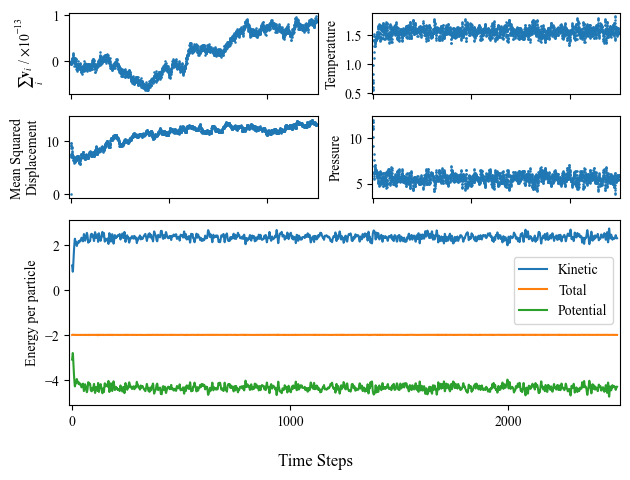

In [11]:

run = 1 # If wanting to edit graphs/mess around with data without doing another simulation run set run to anything other than 1.
save = 1 # Save coordinates
skip = 20 # If generating data files, how many steps to skip per file

fig, axes = plt.subplot_mosaic("AB;CD;EE;EE", sharex=True)

if run==1:

    # Arrays containing the average property (over the particles) per time step

    sumv = np.empty((steps)) # Sum of velocity components
    kinetic = np.empty((steps)) # Kinetic energy
    potential = np.empty((steps)) # Potential energy
    MSD = np.empty((steps)) # Mean squared displacement
    radial_dist = np.empty((steps, len(r_range)-1)) # Radial distribution function
    p = np.empty((steps)) # Pressure

    for i in range(steps):
        if save==1:
            gen_file(r,int(i/skip))

        sumv[i] = np.sum(v)
        potential[i], kinetic[i] = energy(eps, sig, r, v)
        MSD[i] = np.sum((r-r0)**2)
        p[i] = np.sum(np.multiply(force(eps,sig,r)[1],length(r)[0])) # sum of f_ij dot r_ij in virial eqn
        radial_dist[i] = g(r)

        r, v, a = update(r,v,a,dt)

        sys.stdout.write('\r')
        sys.stdout.write("Progress: {:.2%}".format(i/steps))
        sys.stdout.flush()

MSD = MSD/N # Sum already done - this averages over all particles. Leaves one less step in for loop
potential = potential/2 # Double counting correction
E = kinetic + potential
inst_temp = 2*kinetic/(3*N*kb) #Instantaneous temperature of system
p = N*kb*inst_temp/(L**3) + 0.5*p/(3*L**3) # Virial Eqn; Eq. 4.4.2; 0.5 factor to account for double counting

axes["A"].scatter(np.arange(steps), sumv,s=0.7)
axes["A"].yaxis.set_major_formatter(mtick.ScalarFormatter(useMathText=True))
axes["A"].yaxis.get_offset_text().set_visible(False)

axes["B"].scatter(np.arange(steps), inst_temp, label="Temp", s=0.7)
axes["B"].set_ylabel("Temperature")
axes["B"].yaxis.set_major_formatter(FormatStrFormatter('%.1f'))

axes["C"].scatter(np.arange(steps), MSD, label="MSD", s=0.7)
axes["C"].set_ylabel("Mean Squared \n" + "Displacement")

axes["D"].scatter(np.arange(steps), p, label="Pressure", s=0.7)
axes["D"].set_ylabel("Pressure")

axes["E"].plot(np.arange(steps), kinetic/N, label="Kinetic")
axes["E"].plot(np.arange(steps), E/N, label="Total")
axes["E"].plot(np.arange(steps), potential/N, label = "Potential")
axes["E"].set_ylabel("Energy per particle")
axes["E"].legend(loc="center right", bbox_to_anchor=(1,0.62))

axes["E"].set_xlim(-0.005*steps, 1.005*steps)

fig.supxlabel("Time Steps")

plt.tight_layout(w_pad=0.5)

# Remove scientif notation above the plot for sum of velocities and move it to the y axis label
offset = axes["A"].yaxis.get_major_formatter().get_offset() # Empty string if called before tight_layout
axes["A"].set_ylabel("$ \sum_{i} \mathbf{v}_{i} $" + " / " + offset)

plt.show()


## Measurements

### Thermodynamic Properties

In [15]:
# Properties averaged over all time steps

T_f = np.mean(inst_temp) # Average temperature of system
T_err = np.std(inst_temp)/np.sqrt(N)

KE_f = np.mean(kinetic/N) # Average kinetic energy
KE_err = np.std(kinetic/N)/np.sqrt(N)

U_f = np.mean(potential/N) # Average potential energy
U_err = np.std(potential/N)/np.sqrt(N)

E_f = np.mean(E/N) # Average total energy
E_err = np.std(E/N)/np.sqrt(N)

P_f = np.mean(p) # Average pressure
P_err = np.std(p)/np.sqrt(N)

print("Temperature: {:.5f} +/- {:.5f}". format(T_f, T_err))
print("Kinetic Energy per particle: {:.5f} +/- {:.5f}".format(KE_f, KE_err))
print("Potential Energy per particle: {:.5f} +/- {:.5f}".format(U_f, U_err))
print("Total Energy per particle: {:.5f} +/- {:.5f}".format(E_f, E_err))
print("Pressure: {:.5f} +/- {:.5f}".format(P_f, P_err))


Temperature: 1.56234 +/- 0.00885
Kinetic Energy per particle: 2.34351 +/- 0.01327
Potential Energy per particle: -4.33205 +/- 0.01336
Total Energy per particle: -1.98855 +/- 0.00027
Pressure: 5.61335 +/- 0.05588


### Radial Distribution Function
Ratio of the density to ideal density (if the system was an ideal gas).

Text(0.5, 1.0, 'Radial Distribution Function')

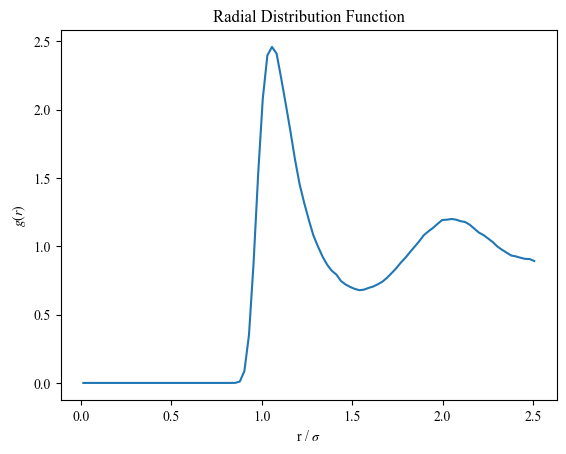

In [16]:
# Normalising g(r)

V = np.empty((len(r_range)-1)) # Volume of each bin

for i in range(len(r_range)-1):
    V[i] = (4/3)*np.pi*(r_range[i+1]**3 - r_range[i]**3)
    
ideal = density * V # Number of particles if ideal gas
mid = 0.5*(r_range[:-1]+r_range[1:]) # Middle of each bin

plt.plot(mid, np.mean(radial_dist, axis=0)/ideal)
plt.xlabel("r / " + "$ \sigma $")
plt.ylabel("$ g (r) $")
plt.title("Radial Distribution Function")